In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, col, coalesce, lit, split, to_date, lower, date_format
from pyspark.sql.types import DateType, FloatType

In [1]:
# Initialize the SparkSession with MongoDB Spark Connector configuration
spark = SparkSession.builder \
    .appName("MongoDBMultipleCollections") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

24/03/02 18:56:40 WARN Utils: Your hostname, Yazhus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.181 instead (on interface en0)
24/03/02 18:56:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/yazhujiang/.ivy2/cache
The jars for the packages stored in: /Users/yazhujiang/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-01ac062e-0f81-4f74-8dfe-0d16ca009ce2;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 114ms :: artifacts dl 6ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   4   |   0   |   0   |   0   ||   4   |   0   |
	---------------------------------------------------------------------
:: retrieving ::

In [21]:
mongodb_host = "localhost"
mongodb_port = "27017"
database_name = "Project697"

collection1_name = "NY_Times_News"
collection1_uri = f"mongodb://{mongodb_host}:{mongodb_port}/{database_name}.{collection1_name}"
collection2_name = "stock"
collection2_uri = f"mongodb://{mongodb_host}:{mongodb_port}/{database_name}.{collection2_name}"

# Read data from the first collection
df_news = spark.read.format("mongo").option("uri", collection1_uri).load()
df_stock = spark.read.format("mongo").option("uri", collection2_uri).load()

In [22]:
selected_df = df_news.select(
    "abstract",
    "headline",
    "lead_paragraph",
    "pub_date",
    "snippet"
)

# Step 2: Format the `pub_date` column
df_news = selected_df.withColumn("pub_date", date_format("pub_date", "yyyy-MM-dd"))
df_news = df_news.withColumn("pub_date", to_date("pub_date", "yyyy-MM-dd"))
df_news = df_news.withColumn("snippet", coalesce(col("snippet"), lit(""))) \
              .withColumn("lead_paragraph", coalesce(col("lead_paragraph"), lit(""))) \
              .withColumn("abstract", coalesce(col("abstract"), lit(""))) \
              .withColumn("headline", coalesce(col("headline"), lit("")))

df_news = df_news.withColumn("combined_text", 
                  lower(concat_ws(" ", 
                                  "snippet", 
                                  "lead_paragraph", 
                                  "abstract", 
                                  "headline")))

# Show the transformed DataFrame
df_news.show(2)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|            abstract|            headline|      lead_paragraph|  pub_date|             snippet|       combined_text|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|Raw Story, AlterN...|Digital Media Out...|The media outlets...|2024-02-28|Raw Story, AlterN...|raw story, altern...|
|The artificial in...|OpenAI Seeks to D...|OpenAI filed a mo...|2024-02-27|The artificial in...|the artificial in...|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
only showing top 2 rows



In [27]:
df_text = df_news.select("pub_date", "combined_text")
df_text.show(2)

+----------+--------------------+
|  pub_date|       combined_text|
+----------+--------------------+
|2024-02-28|raw story, altern...|
|2024-02-27|the artificial in...|
+----------+--------------------+
only showing top 2 rows



In [28]:
from textblob import TextBlob
import pandas as pd

df_text_pandas = df_text.toPandas()

# Function to calculate sentiment
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity  # Returns a value between -1 and 1
    return sentiment

df_text_pandas['sentiment'] = df_text_pandas['combined_text'].apply(get_sentiment)
df_text_sentiment = spark.createDataFrame(df_text_pandas)
df_text_sentiment.show()


+----------+--------------------+--------------------+
|  pub_date|       combined_text|           sentiment|
+----------+--------------------+--------------------+
|2024-02-28|raw story, altern...| -0.2153846153846154|
|2024-02-27|the artificial in...|-0.09350649350649351|
|2024-02-22|amid blowout earn...|-0.03272727272727...|
|2024-02-14|microsoft and ope...|                 0.5|
|2024-02-14|a year ago, a rog...|             -0.2625|
|2024-01-25|the reductions co...|                -0.2|
|2024-01-29|chafing at their ...|                 0.0|
|2024-02-05|profits are up an...| 0.08611111111111112|
|2024-01-19|the hackers appea...|-0.09999999999999999|
|2024-02-01|the iphone maker’...|                0.25|
|2024-01-30|amazon, google, m...| 0.09848484848484848|
|2024-01-30|the sector is lay...|                 0.0|
|2024-01-26|the agency is con...|-0.04999999999999999|
|2024-01-25|the agency plans ...|                -0.6|
|2024-01-12|the shift is indi...| 0.08227272727272728|
|2024-01-1

In [25]:
df_stock = df_stock.select("date", "high", "low")
df_stock = df_stock.withColumn("date", col("date").cast(DateType()))
df_stock = df_stock.withColumn("high", col("high").cast(FloatType())) \
                               .withColumn("low", col("low").cast(FloatType()))
df_stock.show(2)

+----------+-------+------+
|      date|   high|   low|
+----------+-------+------+
|2024-03-01| 211.06|207.41|
|2024-02-29|207.465|204.64|
+----------+-------+------+
only showing top 2 rows



In [29]:
df_joined = df_text_sentiment.join(df_stock, df_text_sentiment.pub_date == df_stock.date, "inner")
df_joined.show()


+----------+--------------------+--------------------+----------+------+------+
|  pub_date|       combined_text|           sentiment|      date|  high|   low|
+----------+--------------------+--------------------+----------+------+------+
|2024-02-05|profits are up an...| 0.08611111111111112|2024-02-05|203.28| 200.8|
|2024-02-05|job cuts, which c...|  0.3190476190476191|2024-02-05|203.28| 200.8|
|2024-02-05|the people on 4ch...|-0.18114478114478116|2024-02-05|203.28| 200.8|
|2024-02-05|profits are up an...| 0.08611111111111112|2024-02-05|203.28| 200.8|
|2024-02-05|the company laid ...| 0.25142045454545453|2024-02-05|203.28| 200.8|
|2024-02-05|the latest data o...| 0.17409648432375704|2024-02-05|203.28| 200.8|
|2024-02-05|profits are up an...| 0.08611111111111112|2024-02-05|203.28| 200.8|
|2024-02-05|job cuts, which c...|  0.3190476190476191|2024-02-05|203.28| 200.8|
|2024-02-05|the people on 4ch...|-0.18114478114478116|2024-02-05|203.28| 200.8|
|2024-02-05|the company laid ...| 0.2514

# Analyze

In [30]:
df_joined_pandas = df_joined.toPandas()
df_joined_pandas['date'] = pd.to_datetime(df_joined_pandas['date'])
df_joined_pandas.sort_values('date', inplace=True)

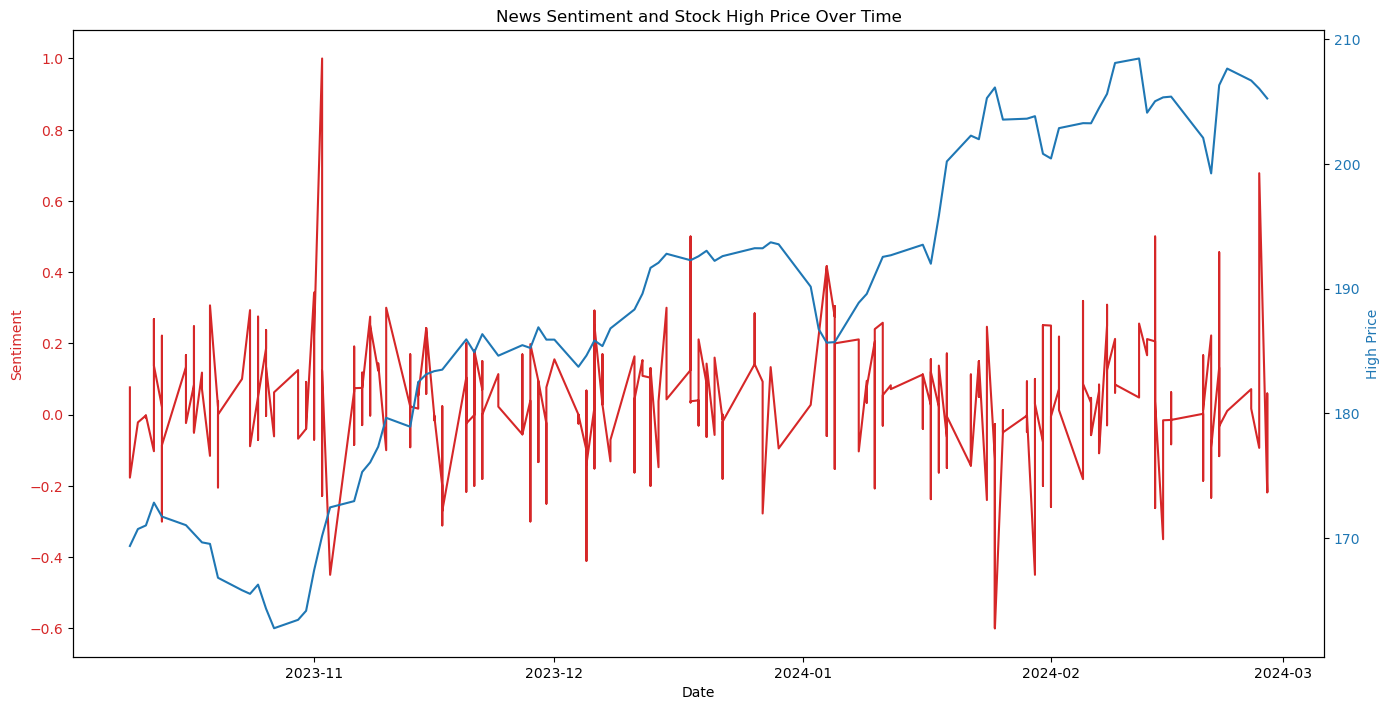

In [31]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment', color=color)
ax1.plot(df_joined_pandas['date'], df_joined_pandas['sentiment'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('High Price', color=color)
ax2.plot(df_joined_pandas['date'], df_joined_pandas['high'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('News Sentiment and Stock High Price Over Time')
plt.show()


Correlation coefficient: -0.02075201307406969
P-value: 0.5650574187920671
Correlation with lag of 1 day(s): -0.019312736457770777
Correlation with lag of 2 day(s): -0.018981568851086237
Correlation with lag of 3 day(s): -0.01660119011623548
Correlation with lag of 4 day(s): -0.017889062199462753
Correlation with lag of 5 day(s): -0.014660073562270858
Correlation with lag of 6 day(s): -0.01232806759104333
Correlation with lag of 7 day(s): -0.011117211690300603
Correlation with lag of 8 day(s): -0.006251167624303665
Correlation with lag of 9 day(s): -0.003817610700482572


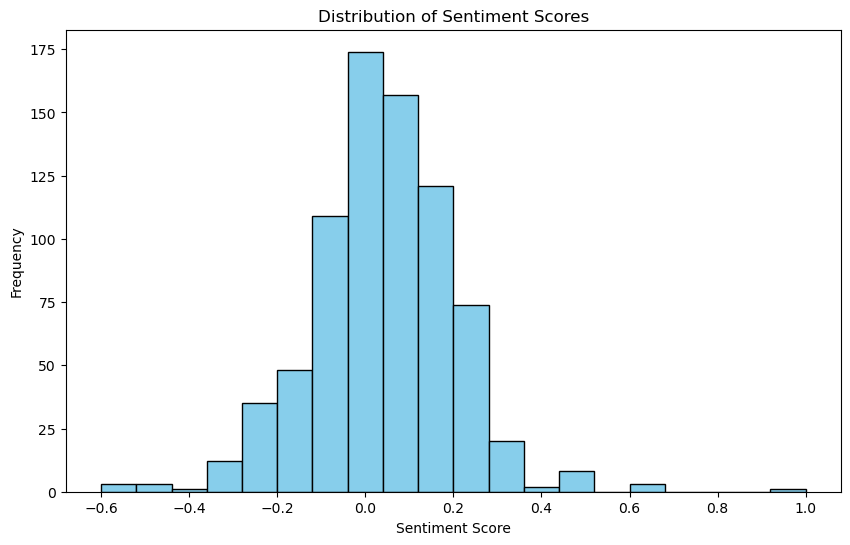

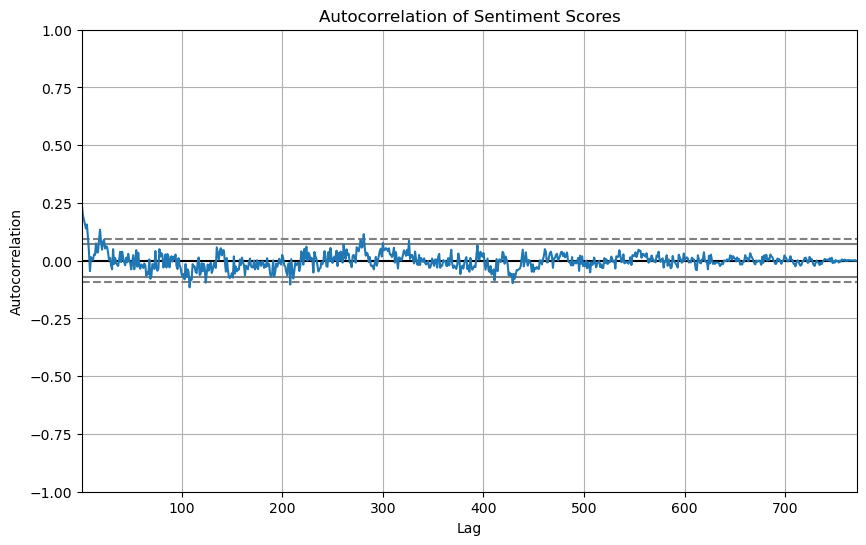

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind
from pandas.plotting import lag_plot, autocorrelation_plot

# Let's assume your DataFrame is named df_joined_pandas and it has 'sentiment', 'high' columns

# Convert date to datetime if it's not already
df_joined_pandas['date'] = pd.to_datetime(df_joined_pandas['date'])

# Sort by date to ensure proper alignment in time-series
df_joined_pandas = df_joined_pandas.sort_values('date')

# Correlation Analysis
correlation, p_value = pearsonr(df_joined_pandas['sentiment'], df_joined_pandas['high'])
print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Lagged Correlation
# Here we are shifting sentiment to find correlation with previous days' sentiment
lags = range(1, 10)  # Check for lag of up to 10 days
for lag in lags:
    sentiment_lagged = df_joined_pandas['sentiment'].shift(lag)
    corr, _ = pearsonr(sentiment_lagged.dropna(), df_joined_pandas['high'][lag:])
    print(f"Correlation with lag of {lag} day(s): {corr}")

# Sentiment Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(df_joined_pandas['sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Autocorrelation of Sentiment
plt.figure(figsize=(10, 6))
autocorrelation_plot(df_joined_pandas['sentiment'])
plt.title('Autocorrelation of Sentiment Scores')
plt.show()

# If you want to predict future stock prices, you might consider a simple linear regression model
# Here's an example using NumPy, but for real predictive modeling, consider scikit-learn or statsmodels
# First, ensure no NaN values
df_joined_pandas = df_joined_pandas.dropna(subset=['sentiment', 'high'])
X = df_joined_pandas['sentiment'].values.reshape(-1, 1)  # Features
y = df_joined_pandas['high'].values  # Target

# XGboost -- only sentiment score

Mean Squared Error: 131.77061462402344
R^2 score: 0.21158222963119067


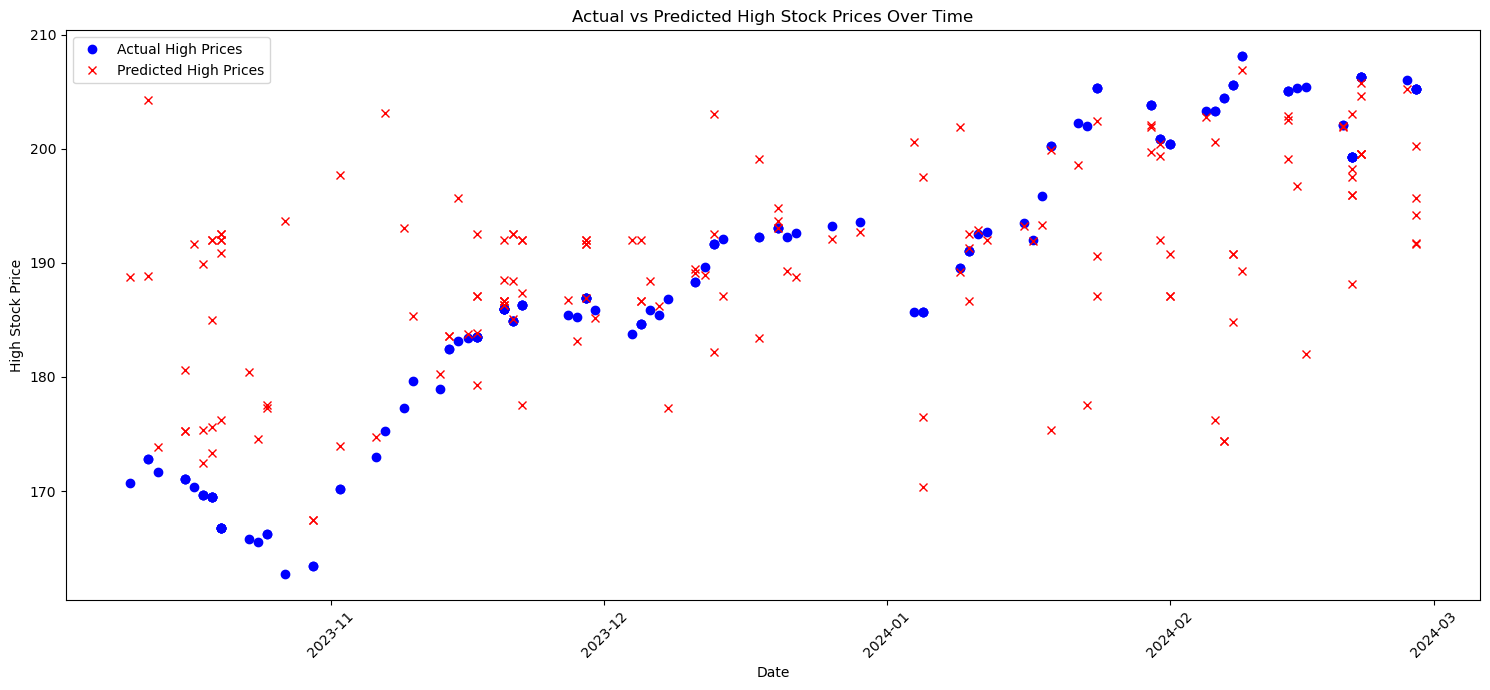

In [54]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Assuming df_joined_pandas has 'sentiment' and 'high' columns
X = df_joined_pandas[['sentiment']]  # Features - in this case, just sentiment
y = df_joined_pandas['high']  # Target - stock high price

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate XGBRegressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = xg_reg.predict(X_test)

# Compute and print the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")


test_dates = df_joined_pandas.loc[X_test.index, 'pub_date']

# Create a DataFrame from y_pred
y_pred_df = pd.DataFrame(y_pred, index=X_test.index)
y_pred_df['pub_date'] = test_dates
y_pred_df = y_pred_df.sort_values(by='pub_date')

# Create a DataFrame from y_test for plotting
y_test_df = pd.DataFrame(y_test).sort_index()
y_test_df['pub_date'] = df_joined_pandas.loc[y_test.index, 'pub_date']
y_test_df = y_test_df.sort_values(by='pub_date')

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(y_test_df['pub_date'], y_test_df['high'], label='Actual High Prices', marker='o', linestyle='', color='blue')
plt.plot(y_pred_df['pub_date'], y_pred_df[0], label='Predicted High Prices', marker='x', linestyle='', color='red')
plt.title('Actual vs Predicted High Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('High Stock Price')
plt.xticks(rotation=45)  # Rotate the dates for better readability
plt.legend()
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()



# XGboost -- sentiment score with text

Mean Squared Error: 54.52849197387695
R^2 score: 0.673741861104976


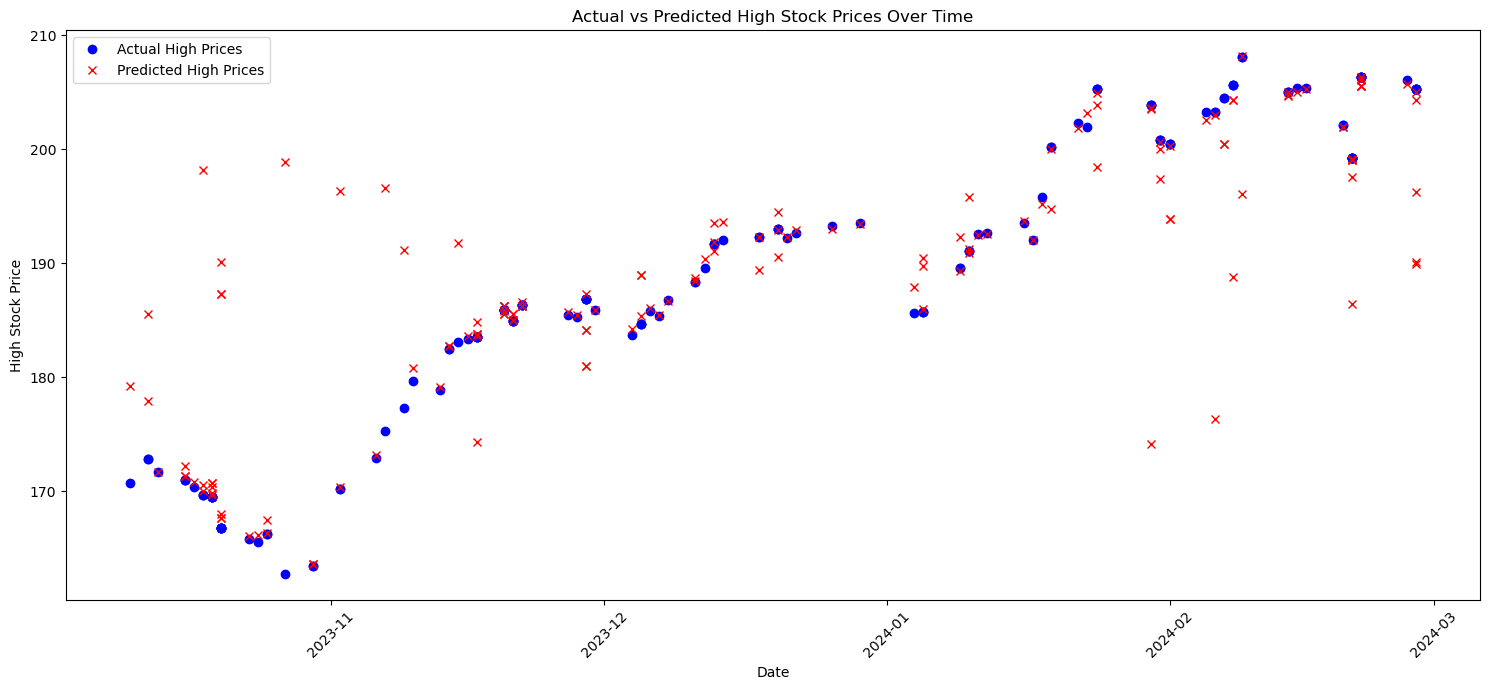

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# Split the data into training and test sets
# Assuming 'sentiment' is another feature you want to include alongside the text data
X_train, X_test, y_train, y_test, train_dates, test_dates = train_test_split(
    df_joined_pandas[['combined_text', 'sentiment']], 
    df_joined_pandas['high'], 
    df_joined_pandas['pub_date'], # keeping the dates for plotting
    test_size=0.2, 
    random_state=42
)

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Fit on the training data and transform both training and test sets
X_train_tfidf = tfidf.fit_transform(X_train['combined_text'])
X_test_tfidf = tfidf.transform(X_test['combined_text'])

# Convert the 'sentiment' column to a sparse matrix and concatenate with TF-IDF features
X_train_sentiment = csr_matrix(X_train['sentiment']).T
X_test_sentiment = csr_matrix(X_test['sentiment']).T

X_train_features = hstack([X_train_tfidf, X_train_sentiment])
X_test_features = hstack([X_test_tfidf, X_test_sentiment])

xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

xg_reg.fit(X_train_features, y_train)
y_pred = xg_reg.predict(X_test_features)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")

# Plotting the actual vs predicted values using the dates for x-axis
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test, label='Actual High Prices', marker='o', linestyle='none', color='blue')
plt.plot(test_dates, y_pred, label='Predicted High Prices', marker='x', linestyle='none', color='red')
plt.title('Actual vs Predicted High Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('High Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
# Resample to weekly or monthly sentiment averages and stock high prices
weekly_sentiment = df_joined_pandas.resample('W', on='date')['sentiment'].mean()
weekly_high = df_joined_pandas.resample('W', on='date')['high'].mean()

# Now you can calculate the correlation on these aggregated values
correlation, p_value = pearsonr(weekly_sentiment, weekly_high)
print(f"Weekly Correlation coefficient: {correlation}")
print(f"Weekly P-value: {p_value}")


Weekly Correlation coefficient: -0.10514700874264464
Weekly P-value: 0.6501165441792943


In [57]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'sentiment' is the time series you want to model
model = ARIMA(df_joined_pandas['sentiment'], order=(5,1,0))  # The order (p,d,q) needs to be selected appropriately
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                  771
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 324.783
Date:                Sat, 02 Mar 2024   AIC                           -637.566
Time:                        20:01:57   BIC                           -609.687
Sample:                             0   HQIC                          -626.837
                                - 771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7447      0.029    -25.938      0.000      -0.801      -0.688
ar.L2         -0.5658      0.037    -15.430      0.000      -0.638      -0.494
ar.L3         -0.4147      0.039    -10.722      0.0

/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Assuming 'df_joined_pandas' is your DataFrame and it has 'date' and 'high' columns
df_joined_pandas['date'] = pd.to_datetime(df_joined_pandas['date'])
df_joined_pandas.set_index('date', inplace=True)

# Focus on the 'high' prices
time_series = df_joined_pandas['high']


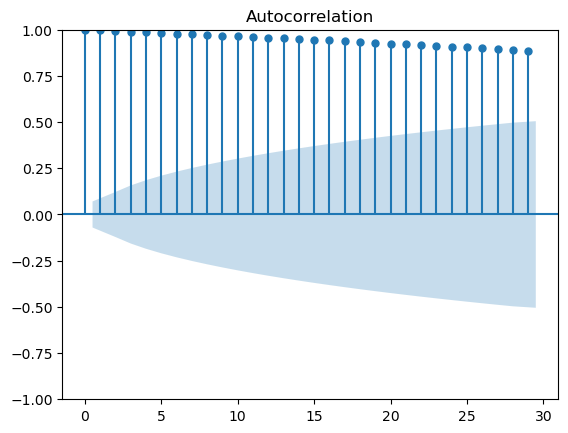

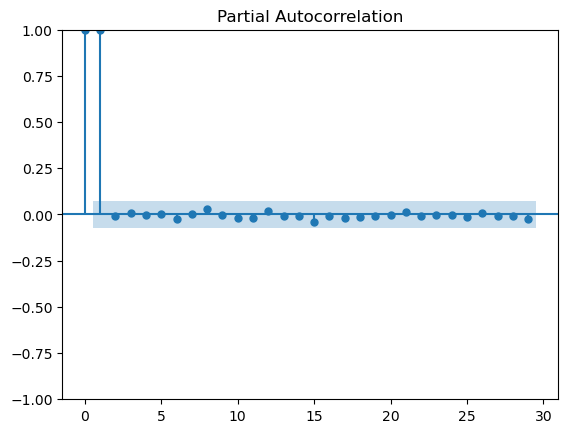

In [60]:
plot_acf(time_series)
plt.show()

plot_pacf(time_series)
plt.show()


In [69]:
# Define the split point
split_point = int(len(time_series) * 0.8)  # 80% for training, 20% for testing

# Split the data
train_data = time_series[:split_point]
test_data = time_series[split_point:]

model = ARIMA(train_data, order=(2, 1, 0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   high   No. Observations:                  616
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -562.652
Date:                Sat, 02 Mar 2024   AIC                           1131.304
Time:                        20:11:41   BIC                           1144.569
Sample:                             0   HQIC                          1136.462
                                - 616                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0165      0.101      0.163      0.870      -0.182       0.215
ar.L2          0.0702      0.033      2.147      0.032       0.006       0.134
sigma2         0.3649      0.007     55.733      0.0

/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/envs/DistributedComputing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


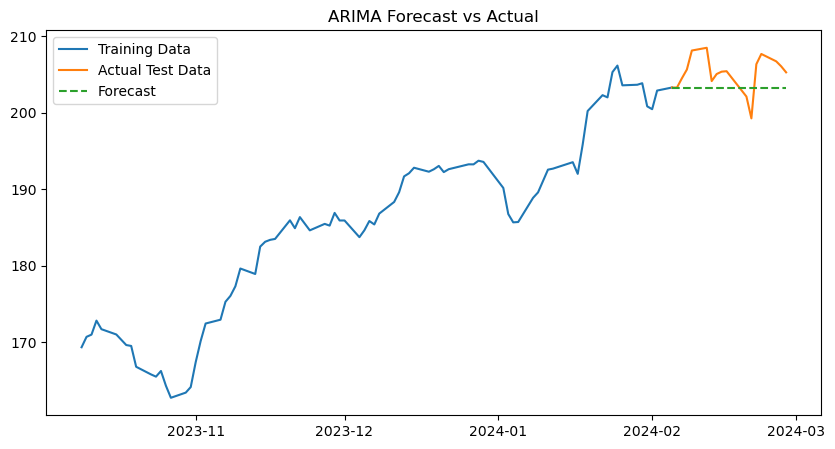

In [70]:
predictions = model_fit.forecast(steps=len(test_data))

# Plot the training data, test data, and the forecast on the same plot
plt.figure(figsize=(10,5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, predictions, label='Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()



In [18]:
spark.stop()